### Model training 

#### Libraries

In [1]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-10-13 23:51:08.715436: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 23:51:09.061045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-13 23:51:10.122600: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Enable GPU 

In [2]:
# GPU
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  1


2025-10-13 23:51:17.114411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-13 23:51:17.317730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-13 23:51:17.317965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

#### Load dataset

In [3]:
# Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0          


#### Fashion MNIST: classes

| Label | Class |  
|-----------|-----------|
|0  | T-shirt/top	   |
|1	|Trouser    |
|2	|Pullover|
|3	|Dress|
|4	|Coat|
|5	|Sandal|
|6	|Shirt|
|7	|Sneaker|
|8	|Bag	|
|9	|Ankle boot|

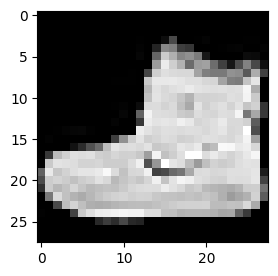

In [8]:
# Image index

N = 0

plt.figure(figsize=(3,3))
plt.imshow(x_train[N], cmap='gray')

In [9]:
# Labels
y_train[0]

9

### Model definition



In [10]:
# MLP architecture

w = 28
h = 28
n_classes = 10

model= Sequential([

    Flatten(input_shape=(w, h)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')

])


2025-10-13 23:53:53.275042: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1d565c40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-10-13 23:53:53.275148: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2025-10-13 23:53:53.275726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-13 23:53:53.276159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
20

### Build model

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 219,818
Trainable params: 219,818
Non-trai

In [12]:
lr = 0.001
# op = Adam(lr)
op = SGD(lr)

model.compile(loss='sparse_categorical_crossentropy', optimizer=op, metrics=['accuracy'])

### Model training

In [13]:
history = model.fit(x_train_norm, y_train, epochs= 32, batch_size = 50, validation_split=0.2)

Epoch 1/32


2025-10-13 23:55:15.543330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2025-10-13 23:55:15.711593: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-10-13 23:55:15.819528: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


960/960 [==============================] - 4s 3ms/step - loss: 2.0029 - accuracy: 0.3605 - val_loss: 1.6091 - val_accuracy: 0.6072
Epoch 2/32
960/960 [==============================] - 2s 3ms/step - loss: 1.3839 - accuracy: 0.6019 - val_loss: 1.0761 - val_accuracy: 0.6762
Epoch 3/32
960/960 [==============================] - 2s 3ms/step - loss: 1.0312 - accuracy: 0.6605 - val_loss: 0.8686 - val_accuracy: 0.7048
Epoch 4/32
960/960 [==============================] - 2s 2ms/step - loss: 0.8869 - accuracy: 0.6938 - val_loss: 0.7779 - val_accuracy: 0.7323
Epoch 5/32
960/960 [==============================] - 2s 3ms/step - loss: 0.8114 - accuracy: 0.7154 - val_loss: 0.7208 - val_accuracy: 0.7526
Epoch 6/32
960/960 [==============================] - 2s 2ms/step - loss: 0.7624 - accuracy: 0.7373 - val_loss: 0.6824 - val_accuracy: 0.7647
Epoch 7/32
960/960 [==============================] - 2s 2ms/step - loss: 0.7220 - accuracy: 0.7517 - val_loss: 0.6510 - val_accuracy: 0.7816
Epoch 8/32
960/96

In [14]:
# Model evaluation
test_loss, test_acc = model.evaluate(x_test_norm, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

313/313 [==============================] - 1s 1ms/step - loss: 0.4668 - accuracy: 0.8363

Test accuracy: 0.8363


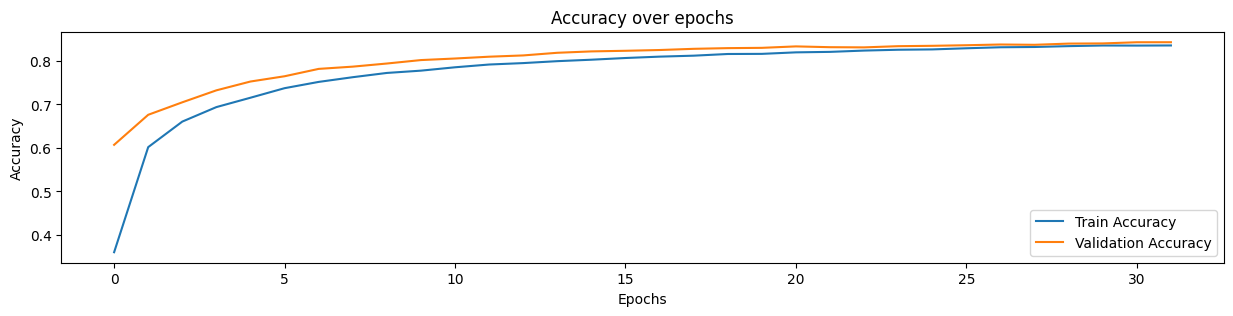

In [15]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

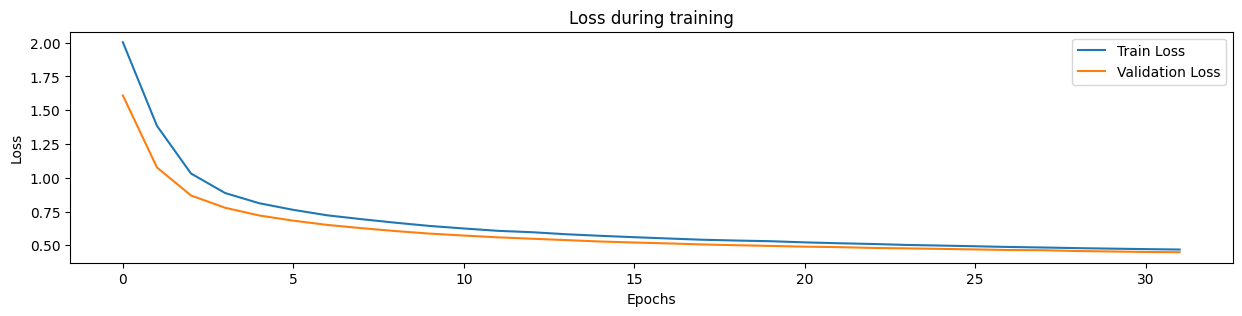

In [16]:
# Plot accuracy over loss
plt.figure(figsize=(15,3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()
plt.show()

### Inference test

1/1 [==============================] - 0s 28ms/step
Predicted Class: 8 - True label: 8


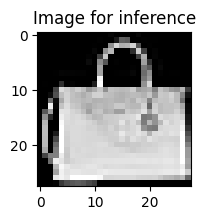

In [25]:

index = 30

plt.figure(figsize=(2,2))
plt.imshow(x_test[index], cmap='gray')
plt.title("Image for inference")

# x_test_norm_reshaped = x_test[index].reshape(-1, 28,28)

y_pred = model.predict(x_test_norm[index].reshape(-1, 28, 28))

y_pred = np.argmax(y_pred) 
print(f"Predicted Class: {y_pred} - True label: {y_test[index]}")

### Confusion Matrix

313/313 [==============================] - 0s 1ms/step


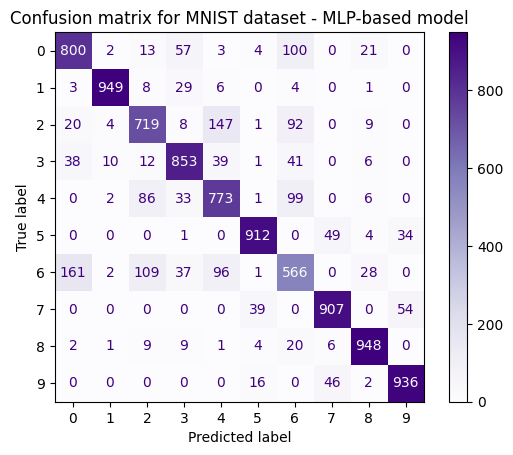

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score


y_pred_probs = model.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Purples')
plt.title('Confusion matrix for MNIST dataset - MLP-based model')
plt.show()

In [21]:
model.save("../models/fashionMNIST.h5")

---
#### UTP - Perú - 2025

Romina Soledad Molina, Ph.D. - MLab/STI ICTP, Trieste, Italy